Configuration des bras:
Bras 0: Gaussien(0, 1) - moyenne = 0
Bras 1: Bernoulli(0.2) - moyenne = 0.2
Bras 2: Bernoulli(0.25) - moyenne = 0.25
Bras optimal: 2 avec moyenne 0.25
Nombre de simulations: 1000
Horizon temporel: 20000

Début des simulations...
Simulation 100/1000
Simulation 200/1000
Simulation 300/1000
Simulation 400/1000
Simulation 500/1000
Simulation 600/1000
Simulation 700/1000
Simulation 800/1000
Simulation 900/1000
Simulation 1000/1000

=== RÉSULTATS ===
Probabilité moyenne des violations: 0.000051
Probabilité maximale: 0.521000
Regret cumulatif final: 198.71
Probabilité maximale atteinte au temps t=1: 0.521000


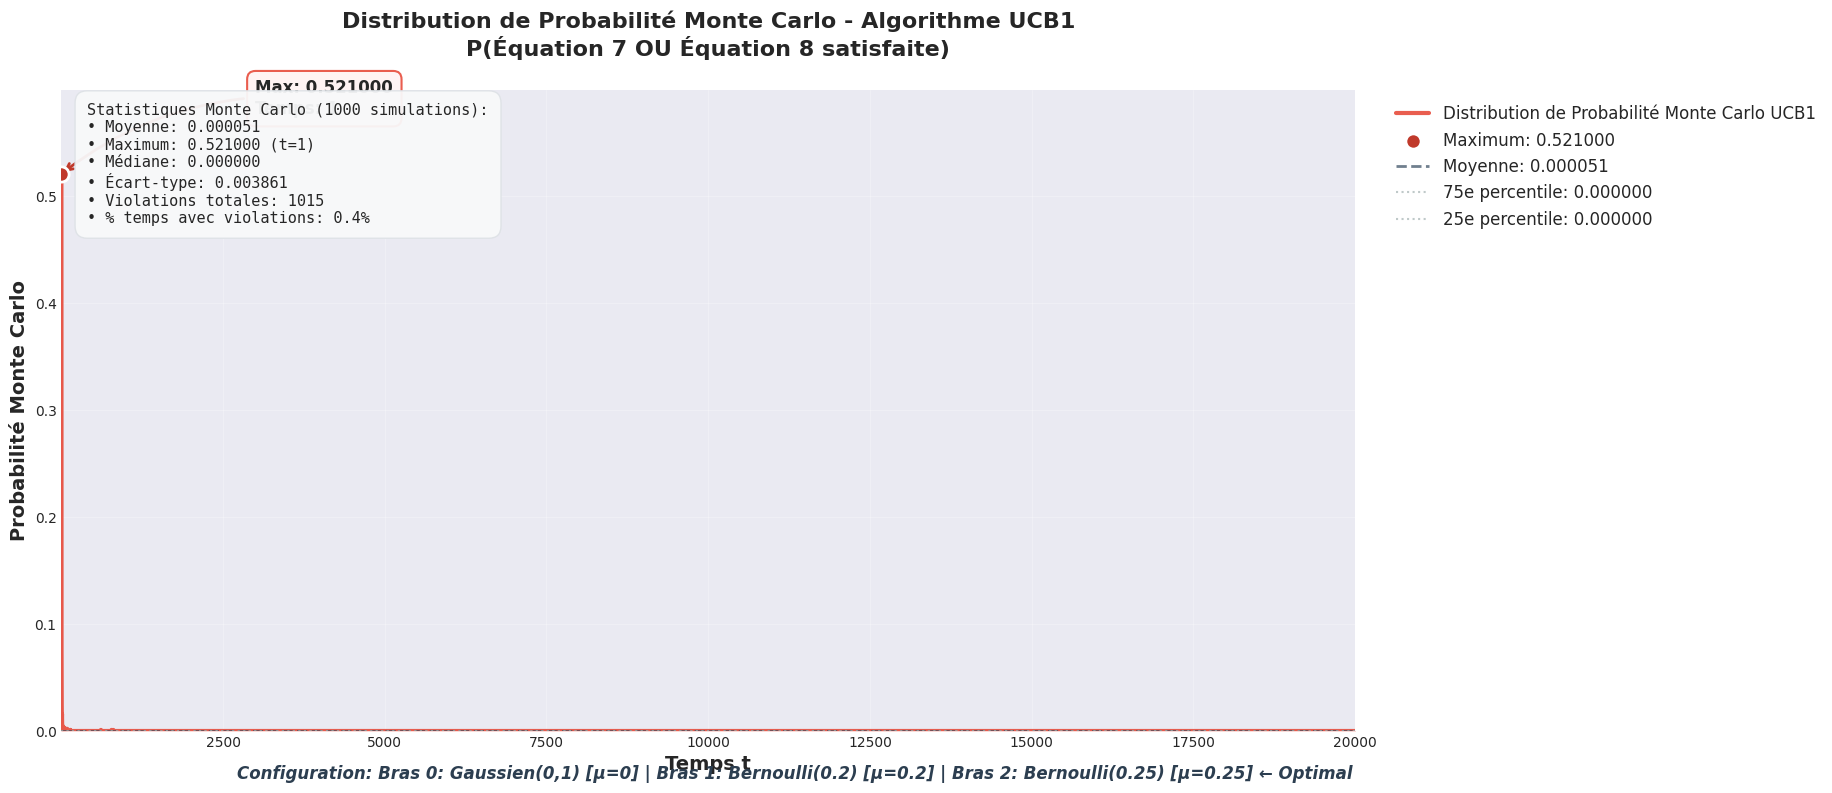

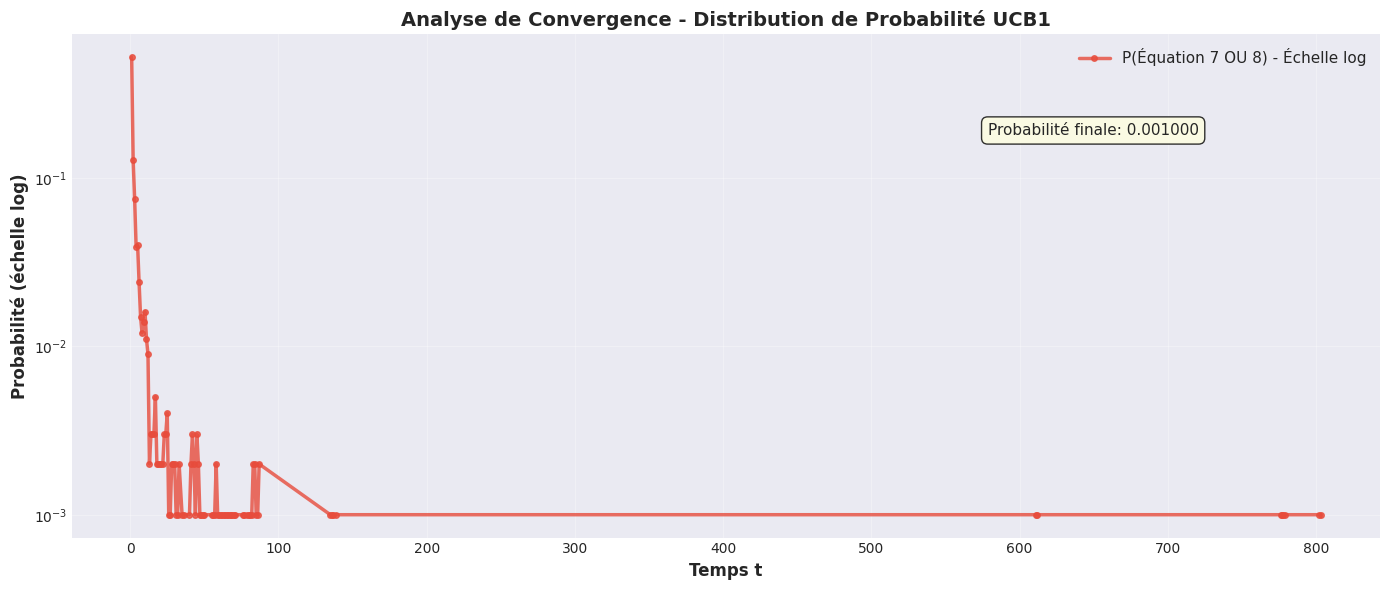


=== ANALYSE DES PREMIERS TOURS ===
Nombre de violations dans les 100 premiers tours: 1.0
Probabilité moyenne sur les 1000 derniers tours: 0.000000

=== TEST DE VALIDATION ===
Violations détectées dans le test de validation: 2/100

Statistiques finales du test:
  Bras 0: empirique = 0.181, vraie = 0.000, tirages = 31
  Bras 1: empirique = 0.172, vraie = 0.200, tirages = 29
  Bras 2: empirique = 0.250, vraie = 0.250, tirages = 40


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Classe pour bras Bernoulli
class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def pull(self):
        return np.random.binomial(1, self.p)

# Classe pour bras Gaussien
class GaussianArm:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def pull(self):
        return np.random.normal(self.mean, self.std)

# UCB1 Classique
class UCB1:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        total_counts = np.sum(self.counts)
        # Phase d'initialisation : jouer chaque bras une fois
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        
        # Phase UCB1
        ucb_values = self.values + np.sqrt((2 * np.log(total_counts)) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] = ((n - 1) / n) * self.values[arm] + (1 / n) * reward

# Paramètres - Configuration identique au code précédent
n_plays = 20000
n_sim = 1000  # Réduit pour des tests plus rapides
print("Configuration des bras:")

# Configuration des bras : Gaussien(0,1), Bernoulli(0.2), Bernoulli(0.25)
arm_configs = [
    ("Gaussien", 0, 1),      # Bras 0: Gaussien standard (mean=0, std=1)
    ("Bernoulli", 0.2, None), # Bras 1: Bernoulli(0.2)
    ("Bernoulli", 0.25, None) # Bras 2: Bernoulli(0.25)
]

# Vraies moyennes des bras
true_means = [0, 0.2, 0.25]
optimal_arm = np.argmax(true_means)  # Bras 2 (Bernoulli 0.25)
mu_max = max(true_means)

print(f"Bras 0: Gaussien(0, 1) - moyenne = {true_means[0]}")
print(f"Bras 1: Bernoulli(0.2) - moyenne = {true_means[1]}")
print(f"Bras 2: Bernoulli(0.25) - moyenne = {true_means[2]}")
print(f"Bras optimal: {optimal_arm} avec moyenne {mu_max}")
print(f"Nombre de simulations: {n_sim}")
print(f"Horizon temporel: {n_plays}")

# Initialisation des bras
def create_arms():
    return [
        GaussianArm(0, 1),      # Bras 0: Gaussien(0,1)
        BernoulliArm(0.2),      # Bras 1: Bernoulli(0.2)
        BernoulliArm(0.25)      # Bras 2: Bernoulli(0.25)
    ]

error_matrix = []
regret_matrix = []

# Simulation principale
print("\nDébut des simulations...")
for sim in range(n_sim):
    if (sim + 1) % 100 == 0:
        print(f"Simulation {sim + 1}/{n_sim}")
    
    # Initialiser l'agent et les bras
    agent = UCB1(n_arms=3)
    arms = create_arms()
    
    # Historique des récompenses pour chaque bras
    rewards = [[] for _ in range(3)]
    errors = []
    cumulative_regret = 0
    regrets = []
    
    for t in range(1, n_plays + 1):
        # Sélectionner un bras
        arm = agent.select_arm()
        
        # Tirer le bras sélectionné et obtenir la récompense
        reward = arms[arm].pull()
        
        # Mettre à jour l'agent
        agent.update(arm, reward)
        rewards[arm].append(reward)
        
        # Calculer le regret instantané
        instantaneous_regret = mu_max - true_means[arm]
        cumulative_regret += instantaneous_regret
        regrets.append(cumulative_regret)
        
        # Calculer les moyennes empiriques et bornes de confiance
        emp_means = [np.mean(r) if len(r) > 0 else 0 for r in rewards]
        s = [len(r) for r in rewards]  # Nombre de tirages par bras
        c_t = [np.sqrt(2 * np.log(t) / si) if si > 0 else np.inf for si in s]
        
        # Détection des erreurs (équations 7 et 8)
        err = 0
        
        # Équation 7: Le bras optimal (bras 2) est sous-estimé
        if s[optimal_arm] > 0 and emp_means[optimal_arm] <= true_means[optimal_arm] - c_t[optimal_arm]:
            err = 1
        
        # Équation 8: Un bras sous-optimal est sur-estimé
        for i in range(3):
            if i != optimal_arm and s[i] > 0:
                if emp_means[i] >= true_means[i] + c_t[i]:
                    err = 1
                    break
        
        errors.append(err)
    
    error_matrix.append(errors)
    regret_matrix.append(regrets)

# Calcul des moyennes Monte Carlo
proba_errors = np.mean(error_matrix, axis=0)
mean_regret = np.mean(regret_matrix, axis=0)

# Statistiques
print(f"\n=== RÉSULTATS ===")
print(f"Probabilité moyenne des violations: {np.mean(proba_errors):.6f}")
print(f"Probabilité maximale: {np.max(proba_errors):.6f}")
print(f"Regret cumulatif final: {mean_regret[-1]:.2f}")

# Moments où la probabilité est maximale
if np.max(proba_errors) > 0:
    max_prob_time = np.argmax(proba_errors) + 1
    print(f"Probabilité maximale atteinte au temps t={max_prob_time}: {np.max(proba_errors):.6f}")

# Création du graphique principal - Distribution de probabilité Monte Carlo
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

time_steps = np.arange(1, len(proba_errors) + 1)

# Courbe principale avec style élégant
ax.plot(time_steps, proba_errors, color='#e74c3c', linewidth=3, 
        label="Distribution de Probabilité Monte Carlo UCB1", alpha=0.9)

# Zone d'ombre élégante
ax.fill_between(time_steps, 0, proba_errors, color='#e74c3c', alpha=0.2)

# Marquer les points remarquables
max_prob_idx = np.argmax(proba_errors)
max_prob_time = max_prob_idx + 1
max_prob_val = proba_errors[max_prob_idx]

# Point maximum
ax.scatter([max_prob_time], [max_prob_val], color='#c0392b', s=120, zorder=5, 
           edgecolors='white', linewidth=2, label=f'Maximum: {max_prob_val:.6f}')

# Annotation du maximum
ax.annotate(f'Max: {max_prob_val:.6f}\nTemps: {max_prob_time}', 
            xy=(max_prob_time, max_prob_val), 
            xytext=(max_prob_time + 3000, max_prob_val + np.max(proba_errors) * 0.1),
            fontsize=12, ha='left', va='bottom', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='#fff2f2', alpha=0.9, 
                     edgecolor='#e74c3c', linewidth=1.5),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', 
                           color='#c0392b', lw=2))

# Ligne de moyenne
mean_prob = np.mean(proba_errors)
ax.axhline(y=mean_prob, color='#34495e', linestyle='--', linewidth=2, alpha=0.7,
           label=f'Moyenne: {mean_prob:.6f}')

# Zone de confiance (percentiles)
if np.max(proba_errors) > 0:
    p75 = np.percentile(proba_errors, 75)
    p25 = np.percentile(proba_errors, 25)
    ax.axhline(y=p75, color='#95a5a6', linestyle=':', alpha=0.6, label=f'75e percentile: {p75:.6f}')
    ax.axhline(y=p25, color='#95a5a6', linestyle=':', alpha=0.6, label=f'25e percentile: {p25:.6f}')

# Configuration des axes
ax.set_xlabel("Temps t", fontsize=14, fontweight='bold')
ax.set_ylabel("Probabilité Monte Carlo", fontsize=14, fontweight='bold')
ax.set_title("Distribution de Probabilité Monte Carlo - Algorithme UCB1\nP(Équation 7 OU Équation 8 satisfaite)", 
             fontsize=16, fontweight='bold', pad=25)

# Grille personnalisée
ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Légende élégante
ax.legend(fontsize=12, framealpha=0.95, fancybox=True, shadow=True, 
          bbox_to_anchor=(1.02, 1), loc='upper left')

# Limites des axes
ax.set_ylim(0, max(0.01, np.max(proba_errors) * 1.15))
ax.set_xlim(1, n_plays)

# Statistiques détaillées dans un encadré
stats_text = f"""Statistiques Monte Carlo ({n_sim} simulations):
• Moyenne: {np.mean(proba_errors):.6f}
• Maximum: {np.max(proba_errors):.6f} (t={max_prob_time})
• Médiane: {np.median(proba_errors):.6f}
• Écart-type: {np.std(proba_errors):.6f}
• Violations totales: {np.sum(proba_errors * n_sim):.0f}
• % temps avec violations: {(np.sum(proba_errors > 0) / len(proba_errors) * 100):.1f}%"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle="round,pad=0.8", facecolor='#f8f9fa', alpha=0.95, 
                 edgecolor='#dee2e6', linewidth=1))

# Configuration en bas
config_text = ("Configuration: Bras 0: Gaussien(0,1) [μ=0] | "
               "Bras 1: Bernoulli(0.2) [μ=0.2] | "
               "Bras 2: Bernoulli(0.25) [μ=0.25] ← Optimal")
fig.text(0.5, 0.02, config_text, ha='center', fontsize=12, 
         style='italic', color='#2c3e50', weight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.08, right=0.85)
plt.show()

# Graphique complémentaire: Évolution en échelle semi-log pour analyse de convergence
plt.figure(figsize=(14, 6))

# Filtrer les valeurs non-nulles pour l'échelle log
nonzero_mask = proba_errors > 0
if np.any(nonzero_mask):
    nonzero_probs = proba_errors[nonzero_mask]
    nonzero_times = time_steps[nonzero_mask]
    
    plt.semilogy(nonzero_times, nonzero_probs, 'o-', color='#e74c3c', 
                linewidth=2.5, markersize=4, alpha=0.8,
                label="P(Équation 7 OU 8) - Échelle log")
    
    # Ligne de tendance théorique
    if len(nonzero_times) > 100:
        # Fit polynomial sur les logs pour estimer la pente
        log_probs = np.log(nonzero_probs)
        log_times = np.log(nonzero_times)
        
        # Régression linéaire sur les logs
        coeffs = np.polyfit(log_times[-1000:], log_probs[-1000:], 1)  # Derniers 1000 points
        slope = coeffs[0]
        
        # Ligne de référence
        ref_times = nonzero_times[-1000:]
        ref_line = np.exp(coeffs[1]) * (ref_times ** slope)
        plt.semilogy(ref_times, ref_line, '--', color='#f39c12', linewidth=3,
                    alpha=0.8, label=f'Tendance: t^{{{slope:.2f}}}')
    
    plt.xlabel("Temps t", fontsize=12, fontweight='bold')
    plt.ylabel("Probabilité (échelle log)", fontsize=12, fontweight='bold')
    plt.title("Analyse de Convergence - Distribution de Probabilité UCB1", 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11, framealpha=0.9)
    
    # Annotations de convergence
    if len(nonzero_probs) > 0:
        final_prob = nonzero_probs[-1] if len(nonzero_probs) > 0 else 0
        plt.text(0.7, 0.8, f'Probabilité finale: {final_prob:.6f}', 
                transform=plt.gca().transAxes, fontsize=11,
                bbox=dict(boxstyle="round,pad=0.4", facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucune violation détectée - impossible de créer l'analyse de convergence")

# Analyse détaillée des premiers tours pour debug
print(f"\n=== ANALYSE DES PREMIERS TOURS ===")
early_violations = np.sum([proba_errors[i] for i in range(min(100, len(proba_errors)))])
print(f"Nombre de violations dans les 100 premiers tours: {early_violations:.1f}")

# Analyse de convergence
if len(proba_errors) >= 1000:
    final_1000 = np.mean(proba_errors[-1000:])
    print(f"Probabilité moyenne sur les 1000 derniers tours: {final_1000:.6f}")

# Test de validation rapide
print(f"\n=== TEST DE VALIDATION ===")
test_agent = UCB1(n_arms=3)
test_arms = create_arms()
test_violations = 0
test_rewards = [[] for _ in range(3)]

for t in range(1, 101):  # Test sur 100 tours
    arm = test_agent.select_arm()
    reward = test_arms[arm].pull()
    test_agent.update(arm, reward)
    test_rewards[arm].append(reward)
    
    # Vérifier violation
    emp_means = [np.mean(r) if len(r) > 0 else 0 for r in test_rewards]
    s = [len(r) for r in test_rewards]
    c_t = [np.sqrt(2 * np.log(t) / si) if si > 0 else np.inf for si in s]
    
    # Test équations
    violation = False
    if s[optimal_arm] > 0 and emp_means[optimal_arm] <= true_means[optimal_arm] - c_t[optimal_arm]:
        violation = True
    
    for i in range(3):
        if i != optimal_arm and s[i] > 0:
            if emp_means[i] >= true_means[i] + c_t[i]:
                violation = True
                break
    
    if violation:
        test_violations += 1

print(f"Violations détectées dans le test de validation: {test_violations}/100")

# Affichage des statistiques finales du test
print(f"\nStatistiques finales du test:")
final_emp_means = [np.mean(r) if len(r) > 0 else 0 for r in test_rewards]
final_counts = [len(r) for r in test_rewards]
for i in range(3):
    if final_counts[i] > 0:
        print(f"  Bras {i}: empirique = {final_emp_means[i]:.3f}, vraie = {true_means[i]:.3f}, tirages = {final_counts[i]}")